<a href="https://colab.research.google.com/github/albertusro1/Forecasting-East-Java-Covid-19-Cases-with-ARIMA-and-Streamlit/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from numpy import log
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
import json
import datetime
import matplotlib.dates as mdates

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Import Data

In [2]:
import requests

In [3]:
response = requests.get("https://data.covid19.go.id/public/api/prov_detail_JAWA_TIMUR.json")
data = json.loads(response.text)
data = pd.json_normalize(data['list_perkembangan'])

In [4]:
data.head()

,tanggal,KASUS,MENINGGAL,SEMBUH,DIRAWAT_OR_ISOLASI,AKUMULASI_KASUS,AKUMULASI_SEMBUH,AKUMULASI_MENINGGAL,AKUMULASI_DIRAWAT_OR_ISOLASI
0,1584489600000,7,1,0,6,7,0,1,6
1,1584576000000,3,0,0,3,10,0,1,9
2,1584662400000,9,0,0,9,19,0,1,18
3,1584748800000,9,1,0,8,28,0,2,26
4,1584835200000,14,0,0,14,42,0,2,40


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   tanggal                       541 non-null    int64
 1   KASUS                         541 non-null    int64
 2   MENINGGAL                     541 non-null    int64
 3   SEMBUH                        541 non-null    int64
 4   DIRAWAT_OR_ISOLASI            541 non-null    int64
 5   AKUMULASI_KASUS               541 non-null    int64
 6   AKUMULASI_SEMBUH              541 non-null    int64
 7   AKUMULASI_MENINGGAL           541 non-null    int64
 8   AKUMULASI_DIRAWAT_OR_ISOLASI  541 non-null    int64
dtypes: int64(9)
memory usage: 38.2 KB


# Preprocessing

In [6]:
# Mengubah kolom tanggal menjadi format date
for index, row in data.iterrows():

  temp = row['tanggal']
  row['tanggal'] = datetime.datetime.fromtimestamp(row['tanggal']/1000).strftime('%Y-%m-%d')
  data.replace(to_replace=temp, value=row['tanggal'], inplace=True)

In [7]:
data = data.groupby('tanggal')[['AKUMULASI_KASUS']].sum().reset_index().sort_values('tanggal', ascending=True).reset_index(drop=True)

# Rename tanggal and AKUMULASI_KASUS columns into Date and Total Cases
data = data.reset_index(drop=True)
data.columns = ['Date', 'Total Cases']
data = data.set_index('Date')

In [8]:
# Menampilkan data
data.head()

,Total Cases
Date,
2020-03-18,7
2020-03-19,10
2020-03-20,19
2020-03-21,28
2020-03-22,42


In [9]:
data.tail()

,Total Cases
Date,
2021-09-05,387051
2021-09-06,387412
2021-09-07,388087
2021-09-08,388700
2021-09-09,389208


In [10]:
# Memangkas data
data_awal = data
# data_length = int(4/5 * len(data))
data = data[:'2020-05-18']
data.to_csv('covid_jatim.csv')

# Exploratory Data Analysis

In [11]:
# Visualisasi dataset menggunakan bar plot
fig = go.Figure(go.Bar(x=data.index,
                       y=data['Total Cases'],
                       marker_color='blue'
                      ))

fig.update_layout(title='Total Kasus di Jawa Timur',
                 template='plotly_white',
                 xaxis_title='Tanggal',
                 yaxis_title='Total Kasus'
                 )

fig.show()

## Test Stationarity

In [12]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(data['Total Cases'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  7.503663
p-value                         1.000000
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


## Data Transformation

In [13]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Total Cases'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

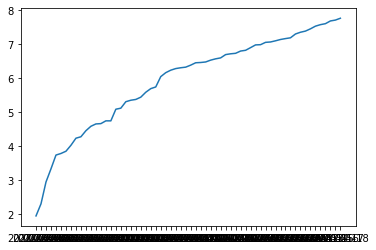

In [14]:
# Log Scale Transformation
data_logScale = np.log(data)
plt.plot(data_logScale)

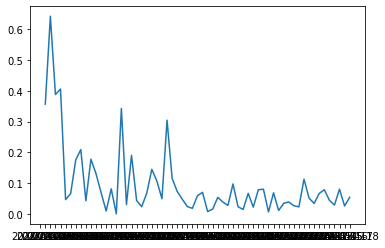

In [15]:
# Time Shift Transformation
datasetLogDiffShifting = data_logScale - data_logScale.shift(1)
plt.plot(datasetLogDiffShifting)

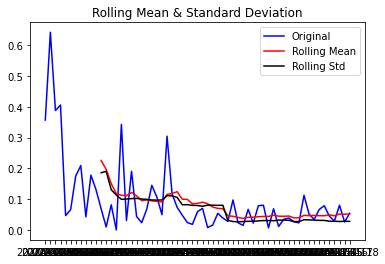

Results of Dickey Fuller Test:
Test Statistic                 -5.357933
p-value                         0.000004
#Lags Used                      1.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [16]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

## Plotting ACF & PACF

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



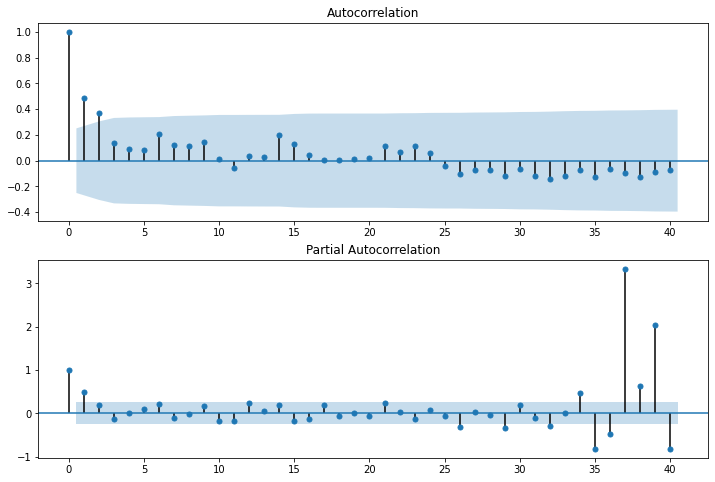

In [17]:
#ACF & PACF plots

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasetLogDiffShifting, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasetLogDiffShifting, lags=40, ax=ax2)#

# Modelling

In [18]:
p = 3 #pacf plot
d = 1 #diff value
q = 1 #acf plot

In [19]:
order = (p,d,q)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Plotting ARIMA model


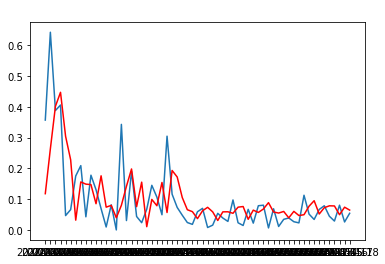

In [20]:
# AR+I+MA = ARIMA model
model = ARIMA(data_logScale, order=order)
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title(' ')
print('Plotting ARIMA model')

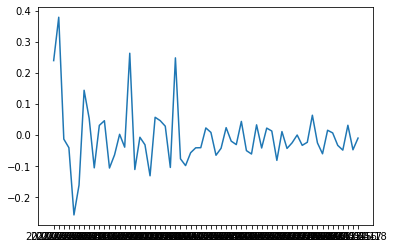

In [21]:
plt.plot(results_ARIMA.resid)

## Prediction & Reverse transformations

In [22]:
def predict(start_index, end_index):

  forecast_nday = results_ARIMA.predict(start=start_index, end=end_index)
  forecast_nday_diff_cumsum = forecast_nday.cumsum()
  forecast_nday_result = forecast_nday_diff_cumsum + float(data_logScale.iloc[-1])
  forecast_nday_result = np.exp(forecast_nday_result)
  forecast_nday_result = forecast_nday_result.values.astype(int)

  return forecast_nday_result

In [23]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

## Predict 1 Week Ahead

In [24]:
days = 7
start_index = len(data_logScale)
end_index = len(data_logScale) + days - 1

In [25]:
data_predict = data_awal.iloc[start_index:end_index+1].copy()
data_predict['Predicted'] = predict(start_index,end_index)

In [26]:
data_predict

,Total Cases,Predicted
Date,,
2020-05-19,2443,2499
2020-05-20,2567,2682
2020-05-21,2998,2894
2020-05-22,3153,3148
2020-05-23,3618,3438
2020-05-24,3690,3778
2020-05-25,3890,4160


In [27]:
data_predict['Difference'] = np.absolute(data_predict['Total Cases'] - data_predict['Predicted'])
mape = MAPE(data_predict['Total Cases'], data_predict['Predicted'])
print('MAPE: ', mape)

MAPE:  3.5286545705168537


In [28]:
data_predict

,Total Cases,Predicted,Difference
Date,,,
2020-05-19,2443,2499,56
2020-05-20,2567,2682,115
2020-05-21,2998,2894,104
2020-05-22,3153,3148,5
2020-05-23,3618,3438,180
2020-05-24,3690,3778,88
2020-05-25,3890,4160,270


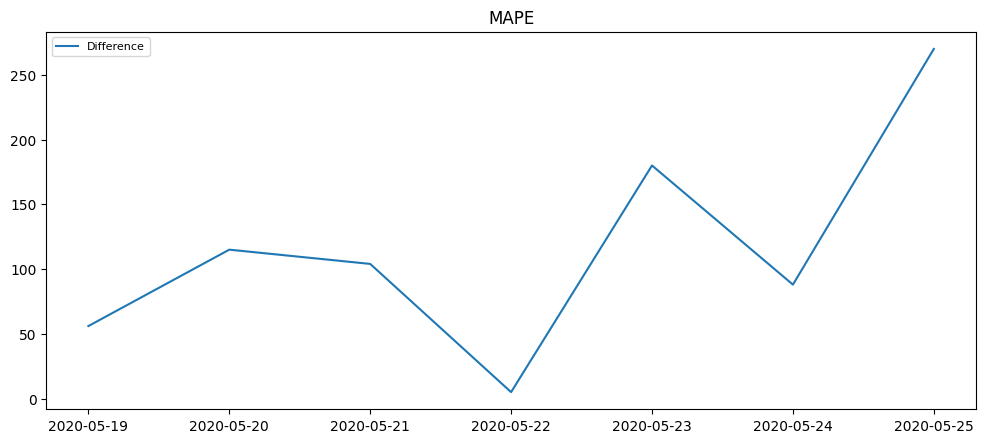

In [29]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_predict['Difference'], label='Difference')
plt.title('MAPE')
plt.legend(loc='upper left', fontsize=8)
plt.show()

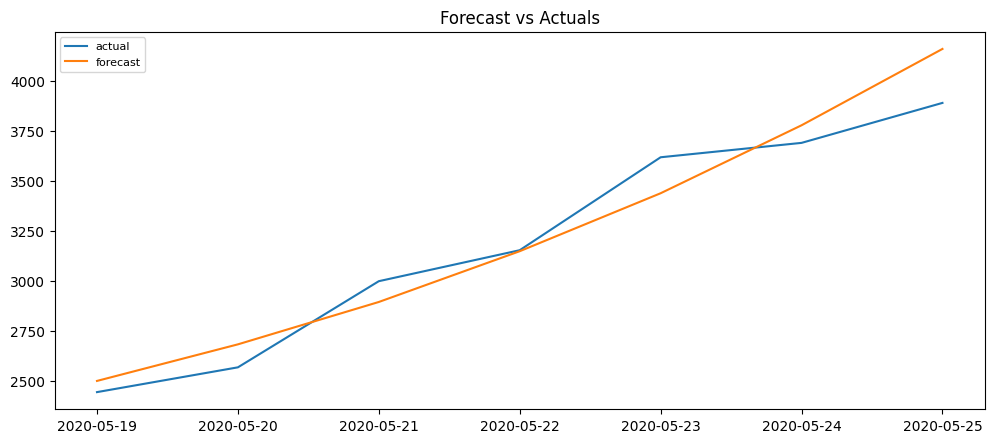

In [30]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_predict['Total Cases'], label='actual')
plt.plot(data_predict['Predicted'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Predict 2 Weeks Ahead

In [31]:
days = 14
start_index = len(data_logScale)
end_index = len(data_logScale) + days - 1

In [32]:
data_predict = data_awal.iloc[start_index:end_index+1].copy()
data_predict['Predicted'] = predict(start_index,end_index)

In [33]:
data_predict

,Total Cases,Predicted
Date,,
2020-05-19,2443,2499
2020-05-20,2567,2682
2020-05-21,2998,2894
2020-05-22,3153,3148
2020-05-23,3618,3438
2020-05-24,3690,3778
2020-05-25,3890,4160
2020-05-26,3976,4603
2020-05-27,4142,5100


In [34]:
data_predict['Difference'] = np.absolute(data_predict['Total Cases'] - data_predict['Predicted'])
mape = MAPE(data_predict['Total Cases'], data_predict['Predicted'])
print('MAPE: ', mape)

MAPE:  23.500044406907218


In [35]:
data_predict

,Total Cases,Predicted,Difference
Date,,,
2020-05-19,2443,2499,56
2020-05-20,2567,2682,115
2020-05-21,2998,2894,104
2020-05-22,3153,3148,5
2020-05-23,3618,3438,180
2020-05-24,3690,3778,88
2020-05-25,3890,4160,270
2020-05-26,3976,4603,627
2020-05-27,4142,5100,958


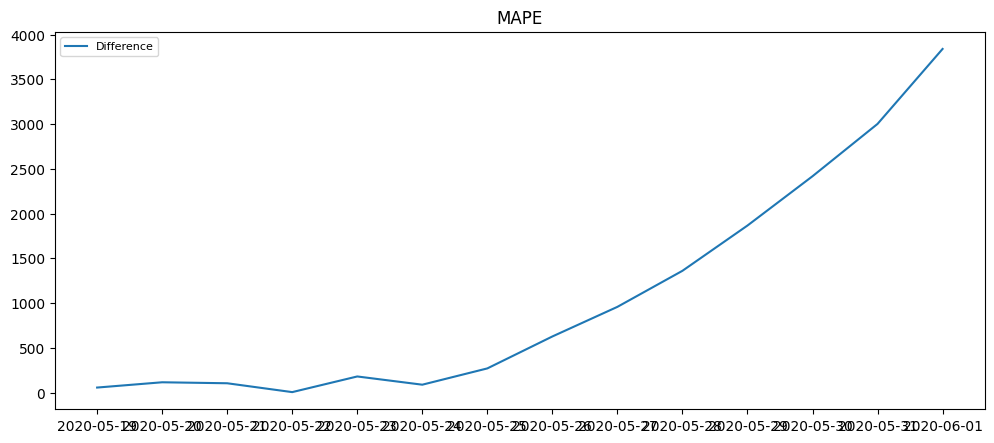

In [36]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_predict['Difference'], label='Difference')
plt.title('MAPE')
plt.legend(loc='upper left', fontsize=8)
plt.show()

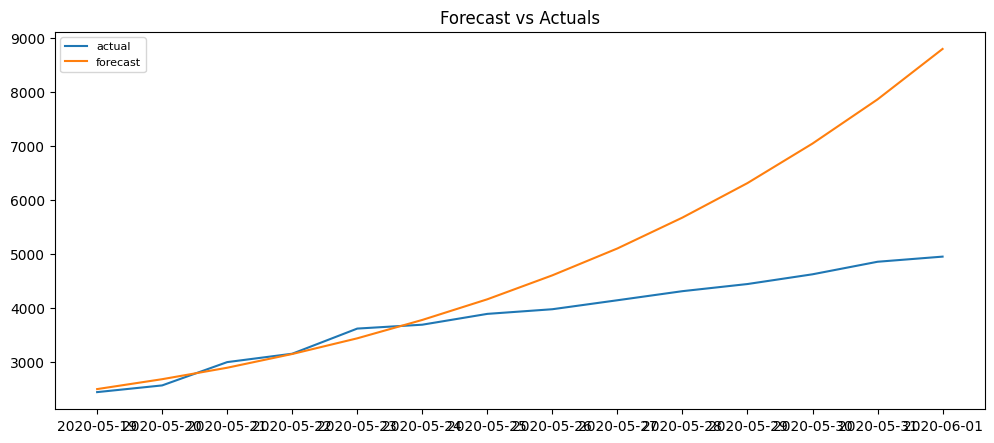

In [37]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_predict['Total Cases'], label='actual')
plt.plot(data_predict['Predicted'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Predict 1 Month Ahead

In [38]:
days = 30
start_index = len(data_logScale)
end_index = len(data_logScale) + days - 1

In [39]:
data_predict = data_awal.iloc[start_index:end_index+1].copy()
data_predict['Predicted'] = predict(start_index,end_index)

In [40]:
data_predict['Difference'] = np.absolute(data_predict['Total Cases'] - data_predict['Predicted'])
mape = MAPE(data_predict['Total Cases'], data_predict['Predicted'])
print('MAPE: ', mape)

MAPE:  162.68247098996682


In [41]:
data_predict

,Total Cases,Predicted,Difference
Date,,,
2020-05-19,2443,2499,56
2020-05-20,2567,2682,115
2020-05-21,2998,2894,104
2020-05-22,3153,3148,5
2020-05-23,3618,3438,180
2020-05-24,3690,3778,88
2020-05-25,3890,4160,270
2020-05-26,3976,4603,627
2020-05-27,4142,5100,958


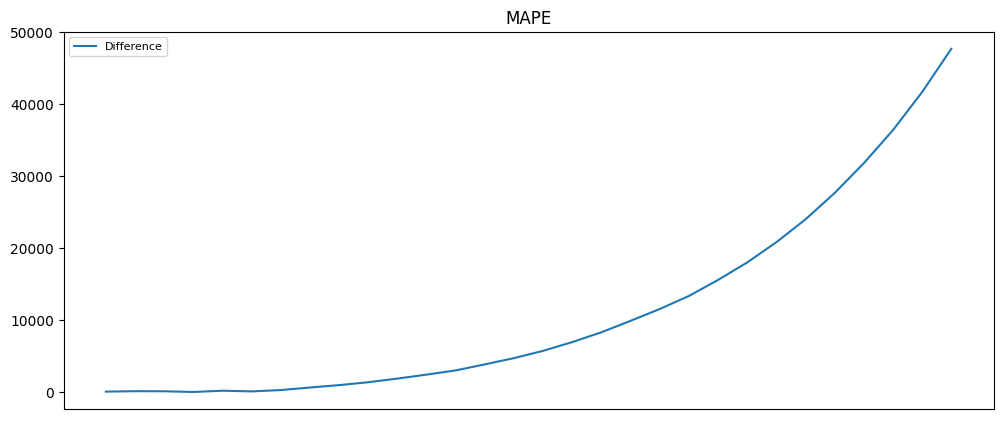

In [42]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_predict['Difference'], label='Difference')
plt.title('MAPE')
plt.legend(loc='upper left', fontsize=8)
plt.gca().xaxis.set_major_locator(mdates.DayLocator((1,7,13,19,25,days)))
plt.show()

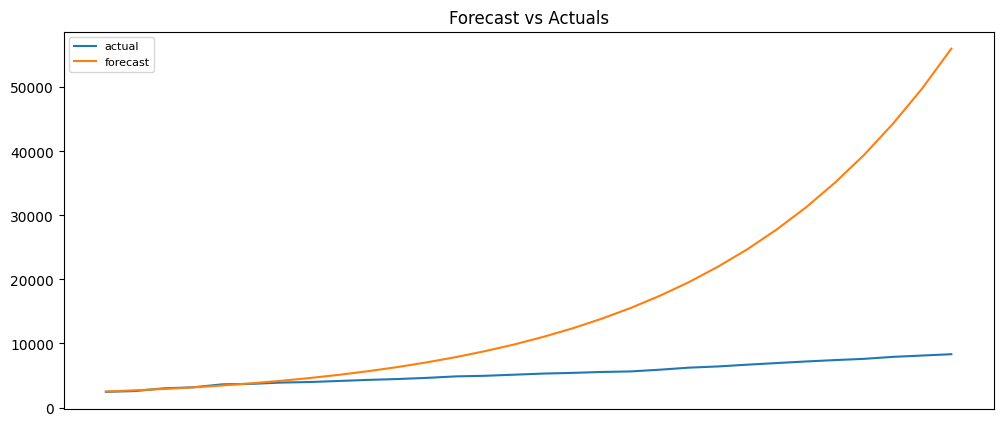

In [43]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_predict['Total Cases'], label='actual')
plt.plot(data_predict['Predicted'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.gca().xaxis.set_major_locator(mdates.DayLocator((1,7,13,19,25,days+1)))
plt.show()